Additional Cleaner in case some of the data still has nans

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset(data):
    # Basic info
    print(f"Dataset shape: {data.shape}")
    
    # Calculate coverage statistics
    total_rows = len(data)
    
    # Create a dataframe to store column statistics
    stats = pd.DataFrame({
        'dtype': data.dtypes,
        'non_null_count': data.count(),
        'null_count': data.isnull().sum(),
        'null_percentage': (data.isnull().sum() / total_rows * 100).round(2),
        'coverage_percentage': ((total_rows - data.isnull().sum()) / total_rows * 100).round(2),
        'unique_values': data.nunique(),
        'unique_percentage': (data.nunique() / total_rows * 100).round(2)
    })
    
    # Add additional statistics for numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        stats.loc[col, 'min'] = data[col].min()
        stats.loc[col, 'max'] = data[col].max()
        stats.loc[col, 'mean'] = data[col].mean()
        stats.loc[col, 'std'] = data[col].std()
        stats.loc[col, 'zeros_percentage'] = (data[col] == 0).sum() / total_rows * 100
    
    # Sort by null percentage
    stats = stats.sort_values('null_percentage', ascending=False)
    
    return stats

def plot_coverage(stats):
    plt.figure(figsize=(12, 8))
    
    # Plot coverage percentage
    coverage_data = stats['coverage_percentage'].sort_values()
    plt.barh(coverage_data.index, coverage_data.values, color='skyblue')
    
    plt.xlabel('Coverage Percentage')
    plt.title('Column Coverage Percentage')
    plt.tight_layout()
    plt.show()
    
    # Plot null percentage for columns with missing values
    null_data = stats[stats['null_percentage'] > 0]['null_percentage'].sort_values(ascending=False)
    
    if len(null_data) > 0:
        plt.figure(figsize=(12, 8))
        plt.barh(null_data.index, null_data.values, color='salmon')
        plt.xlabel('Null Percentage')
        plt.title('Columns with Missing Values')
        plt.tight_layout()
        plt.show()

def identify_low_information_columns(stats, null_threshold=50, unique_threshold=1):
    """Identify columns that might have low information content"""
    
    # Columns with high null percentage
    high_null_cols = stats[stats['null_percentage'] > null_threshold].index.tolist()
    
    # Columns with very few unique values (relative to dataset size)
    low_unique_cols = stats[(stats['unique_percentage'] < unique_threshold) & 
                           (stats['unique_values'] < 5)].index.tolist()
    
    # Columns that are mostly zeros (for numeric columns)
    high_zero_cols = []
    if 'zeros_percentage' in stats.columns:
        high_zero_cols = stats[stats['zeros_percentage'] > 90].index.tolist()
    
    return {
        'high_null_columns': high_null_cols,
        'low_unique_columns': low_unique_cols,
        'high_zero_columns': high_zero_cols
    }

def fill_remaining_nans(data, id_column='cusip', date_column='MthCalDt', method='intelligent'):
    """
    Fill remaining NaN values in the dataset using ffill for all columns except identifiers.
    Then sort the final dataframe by date.
    """
    if data is None or len(data) == 0:
        raise ValueError("No data provided or empty dataframe")
    
    # Make a copy to avoid modifying the original dataframe
    df = data.copy()
    
    # Ensure date column is in datetime format
    if pd.api.types.is_string_dtype(df[date_column]):
        df[date_column] = pd.to_datetime(df[date_column])
    
    # Define identifier columns that should not be filled
    identifier_columns = [
        'cusip', 'gvkey', 'iid', 'datadate', 'tic', 'conm', 'permno', 
        'permco', 'sic', 'naics', 'gics', 'ff49', 'exchg', 'exchcd', 
        'siccd', 'ticker', 'symbol'
    ]
    
    # Keep only the identifier columns that exist in our dataframe
    identifier_columns = [col for col in identifier_columns if col in df.columns]
    
    # Get all non-identifier columns that need to be filled
    columns_to_fill = [col for col in df.columns if col not in identifier_columns]
    
    # Store original NaN counts for reporting
    original_nan_counts = df.isna().sum()
    total_nans_before = original_nan_counts.sum()
    
    print(f"Filling remaining NaN values using forward fill method...")
    print(f"Total NaNs before: {total_nans_before:,}")
    
    # Process each company separately
    company_groups = []
    company_count = df[id_column].nunique()
    print(f"Processing {company_count} companies...")
    
    # Track progress
    processed = 0
    
    # Group by company ID and apply ffill
    for company_id, company_data in df.groupby(id_column):
        # Sort by date within each company group
        company_data = company_data.sort_values(date_column)
        
        # Forward fill all non-identifier columns
        for col in columns_to_fill:
            company_data[col] = company_data[col].fillna(method='ffill')
            # If any NaNs remain at the start of the series, backward fill them
            company_data[col] = company_data[col].fillna(method='bfill')
            # If any NaNs still remain, fill with 0 (for numeric columns only)
            if pd.api.types.is_numeric_dtype(company_data[col]):
                company_data[col] = company_data[col].fillna(0)
        
        # Add the processed company data to our list
        company_groups.append(company_data)
        
        # Update progress
        processed += 1
        if processed % 100 == 0:
            print(f"Processed {processed}/{company_count} companies ({processed/company_count*100:.1f}%)")
    
    # Combine all company data
    df = pd.concat(company_groups, ignore_index=True)
    
    # Report results
    final_nan_counts = df.isna().sum()
    total_nans_after = final_nan_counts.sum()
    
    print(f"Total NaNs after: {total_nans_after:,}")
    print(f"Filled {total_nans_before - total_nans_after:,} NaN values")
    
    # Report columns that still have NaNs
    cols_with_nans = final_nan_counts[final_nan_counts > 0]
    if not cols_with_nans.empty:
        print("\nColumns still containing NaNs:")
        for col, count in cols_with_nans.items():
            print(f"- {col}: {count:,} NaNs ({count/len(df)*100:.2f}%)")
    else:
        print("\nAll NaN values have been filled!")
    
    # Sort the final dataframe by date (oldest first, newest last)
    df = df.sort_values(by=date_column)
    
    return df




Load Data from predictors_and_target.ipynb output dataset (10k and earning calls reports sentiment score)

Filling remaining NaN values using forward fill method...
Total NaNs before: 458,232
Processing 8114 companies...


/tmp/ipykernel_1159/1741668166.py:194: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_data[col] = company_data[col].fillna(method='ffill')
/tmp/ipykernel_1159/1741668166.py:196: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  company_data[col] = company_data[col].fillna(method='bfill')
/tmp/ipykernel_1159/1741668166.py:194: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  company_data[col] = company_data[col].fillna(method='ffill')


Processed 100/8114 companies (1.2%)
Processed 200/8114 companies (2.5%)
Processed 300/8114 companies (3.7%)
Processed 400/8114 companies (4.9%)
Processed 500/8114 companies (6.2%)
Processed 600/8114 companies (7.4%)
Processed 700/8114 companies (8.6%)
Processed 800/8114 companies (9.9%)
Processed 900/8114 companies (11.1%)
Processed 1000/8114 companies (12.3%)
Processed 1100/8114 companies (13.6%)
Processed 1200/8114 companies (14.8%)
Processed 1300/8114 companies (16.0%)
Processed 1400/8114 companies (17.3%)
Processed 1500/8114 companies (18.5%)
Processed 1600/8114 companies (19.7%)
Processed 1700/8114 companies (21.0%)
Processed 1800/8114 companies (22.2%)
Processed 1900/8114 companies (23.4%)
Processed 2000/8114 companies (24.6%)
Processed 2100/8114 companies (25.9%)
Processed 2200/8114 companies (27.1%)
Processed 2300/8114 companies (28.3%)
Processed 2400/8114 companies (29.6%)
Processed 2500/8114 companies (30.8%)
Processed 2600/8114 companies (32.0%)
Processed 2700/8114 companies

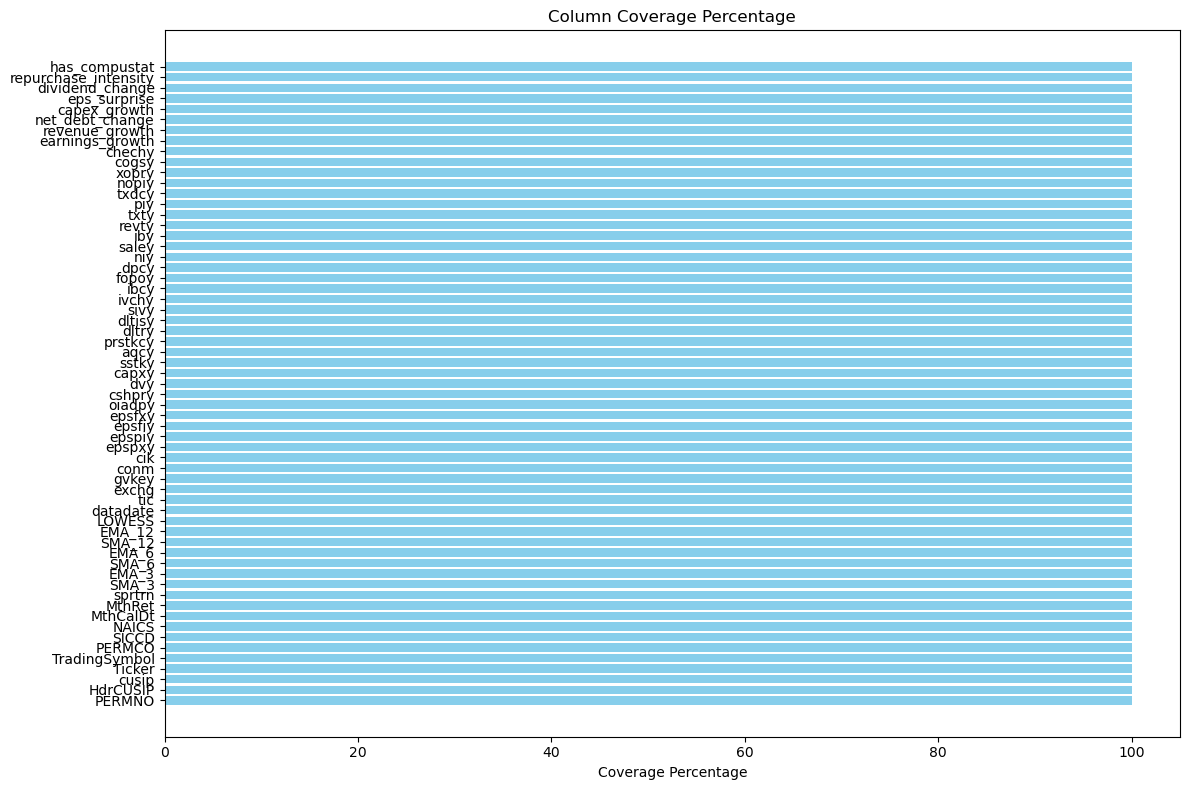


Columns with high null percentage (>50%):
[]

Columns with low unique values:
['has_compustat']

Numeric columns that are mostly zeros (>90%):
[]

Suggested columns to consider removing:
['has_compustat']

Cleaned data saved as 'cleaned_data.csv'


In [ ]:
# Run the above code to clean the data if needed
data = pd.read_csv('datasets/PostProcesed/merged_datasets_with_sentiment.csv')  # Replace with your file path

# Fill remaining NaNs
cleaned_data = fill_remaining_nans(
    data, 
    id_column='cusip',  # Adjust to your company identifier column
    date_column='datadate',  # Adjust to your date column
    method='intelligent'
)

# Run the analysis
stats = analyze_dataset(cleaned_data)

# Display the statistics
print("\nColumn Statistics:")
print(stats)

# Plot the coverage
plot_coverage(stats)

# Identify low information columns
low_info = identify_low_information_columns(stats)

print("\nColumns with high null percentage (>50%):")
print(low_info['high_null_columns'])

print("\nColumns with low unique values:")
print(low_info['low_unique_columns'])

print("\nNumeric columns that are mostly zeros (>90%):")
print(low_info['high_zero_columns'])

# Suggest columns to remove
print("\nSuggested columns to consider removing:")
all_suggested = set(low_info['high_null_columns'] + 
                low_info['low_unique_columns'] + 
                low_info['high_zero_columns'])
print(list(all_suggested))



# Save the cleaned data
cleaned_data.to_csv('merged_compustat_returns_cleaned_data.csv', index=False)
print("\nCleaned data saved as 'cleaned_data.csv'")

Merge sentiment analysis from 10k and Earnings Call to have one unified sentiment

In [ ]:
import numpy as np

df = cleaned_data

# Filter rows where weighted_sentiment_10k != 0
filtered_10k = df[df['weighted_sentiment_10k'] != 0]

# Filter rows where weighted_sentiment_earnings_calls != 0
filtered_earnings = df[df['weighted_sentiment_earnings_calls'] != 0]

# Combine both filtered DataFrames
combined_df = pd.concat([filtered_10k, filtered_earnings])

# Remove duplicate rows (based on all columns)
combined_df = combined_df.drop_duplicates().reset_index(drop=True)

# Group by 'cusip' and count the number of rows in each group
combined_df.groupby('cusip').count()

# Save separate sentiment score if needed
# combined_df.to_csv("combined_sentiment_compustat_returns_separate.csv")

# Create the new column for a unifed sentiment (if both are 0, use 0, if one is 0, use the other, if both are not 0, use the average of the two)
combined_df['unified_sentiment'] = np.where(
    combined_df['weighted_sentiment_10k'] == 0,
    combined_df['weighted_sentiment_earnings_calls'],
    np.where(
        combined_df['weighted_sentiment_earnings_calls'] == 0,
        combined_df['weighted_sentiment_10k'],
        (combined_df['weighted_sentiment_10k'] + combined_df['weighted_sentiment_earnings_calls']) / 2
    )
)

# Remove separate sentiment columns
combined_df = combined_df.drop(columns=['weighted_sentiment_10k', 'weighted_sentiment_earnings_calls'])

combined_df.groupby("cusip").count()

# Save the unified sentiment score
combined_df.to_csv("datasets/PostProcessed/combined_sentiment_compustat_returns_unique.csv")
